<a href="https://colab.research.google.com/github/osiloke/book_em/blob/main/rmlbooks/eceipts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A GenAI tale of a burr'iful state based receipt scanner

In this 2 part post, i will create a receipt scanner using gemini 1.5 for generating the content from the as well as instructor for eforcing correct formatted json.

The major Objectives are
- Utilize GenAI for data extraction from scanned receipts.
- Create a Jupyter notebook with the entire process.

This post will also touch on the following python libraries
- `pydantic` (for structured JSON extraction)
- `instructor` (for translating pydantic to llm request)
- `burr` (for state machine modeling and simulation)
- `google.generativeai` (LLM for generative AI)   
- `PIL` (for processing images)
- `rich` (for pretty printing)

## Part 1 - Scanning Receipts

### Why scan receipts with GenAI?
Well it's actually a health problem. I try as much as possible to eat a healthy meal, given that i spend most of my day in a squat position infront of my p'top.
I spend my morning walking to a nearby grocery store to pick up locally sourced ingredients to make healthy home cooked meals. This started off as a way to distract myself from my p'top but eventually became a sort of lifestyle.

However, i noticed that my grocery bill gradually become more expensive due to subtle changes in price of different items which led me to keep stacks of receipts like a hoarder. I don't love data entry, who does? so obviously i ended up with a pile of papers which was unscalable for a p'top guy with no time.

Besides, papers?. Where tech is going we don't need papers.

![Where tech is going we don't need paper](https://media1.tenor.com/m/3idC48k28zcAAAAd/roads-where-were-going-we-dont-need-roads.gif))



### GenAI Solution, But first...

I struggle with the LLM framework offerings. They are plagued with way too much abstractions which take away control and introspection from it's users. This makes it difficult to dig deep into what exactly the framework is doing with all those sweet `tokens`. There are tools you can use but they are backed by subscriptions et al.

Let's take a simple receipt scanner for managing my daily transactions. I chose to use a library that gives me control, structure, introspection and a simple UI, especially in its application to machine learning.

Introducing [`burr`](https://burr.dagworks.io/), a library which brings functional programming to state management and manages to slide in a bit of visualization and state storage abstraction.

I will talk more about burr much later but For now, watch this [walkthrough](https://www.loom.com/share/a10f163428b942fea55db1a84b1140d8?sid=1512863b-f533-4a42-a2f3-95b13deb07c9) to learn more.

### Receipt scanning as a series of states
Before diving into the main code the receipt scanners states need to be identified. I identified the following basic states of the scanner.

1. Fetch Receipt Image  
2. Extract Receipt Information in JSON
3. Validate Extracted JSON
4. **Step missing**
5. High 5!

Ok, so step 5 is not really a step but when did High 5's stop being cool.

Nonetheles, these steps give a starting point for the functions we need to build our scanner so lets dive into each step.

### But first a little intermission to install dependencies

In [ ]:
%pip install burr instructor pydantic google.generativeai pil rich wget -q


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#rich will be used to print pretty outout
from rich import print

### Step 1 | Fetch Receipt Image

The [expressexpense](https://expressexpense.com/blog/free-receipt-images-ocr-machine-learning-dataset/) receipt dataset is a good source of various types of scanned receipt images that we can play with.

Lets go get it...

In [ ]:
!wget -c https://expressexpense.com/large-receipt-image-dataset-SRD.zip
!mkdir -p receipts
!unzip -q large-receipt-image-dataset-SRD.zip -d receipts

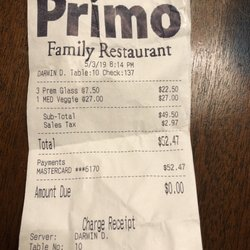

In [ ]:
import os, random
from IPython.display import Image
"""Lets pick a receipt at random"""
receipts = os.listdir('receipts')
random_receipt = random.choice(receipts)
receipt_filename = os.path.join('receipts', random_receipt)
Image(receipt_filename)


### Step 2 | Extract Receipt Information in JSON Format

Lets setup the google generativeai library with the API KEY obtained from google AI studio.

An `API KEY` is required To use gemini 1.5 and you can get one from [ai.google.dev](https://ai.google.dev/gemini-api/docs/api-key).

In [ ]:
import google.generativeai as genai
import os

if os.environ["GOOGLE_API_KEY"] == None:
    api_key = input('Enter API KEY: ')
    os.environ.setdefault("GOOGLE_API_KEY", api_key)
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [ ]:
"""Completion calls can be made easily using the genai library.
Note, the word sexy makes this prompt unsafe, hold on to your hats this prompt is NSFW"""
model = genai.GenerativeModel('gemini-1.5-flash')

safety_settings = [
    {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
        "threshold": "BLOCK_NONE",
    }
]

response = model.generate_content("Who said i'm bringing sexy back and where did it go?", safety_settings=safety_settings)
print(response.text)

The phrase "I'm bringing sexy back" is a lyric from the song **"SexyBack"** by **Justin Timberlake**. 

The song was released in 2006 and became a massive hit, making the phrase popular and synonymous with Timberlake 
himself. 

There's no particular place where "sexy" went, as it's a concept that evolves with fashion, trends, and cultural 
shifts. The phrase was meant to be playful and ironic, suggesting that Timberlake was bringing back a certain style
of sex appeal.

Ok google, sheesh 🙄

That was a bit wordy, let's try to constrain gemini's response so as to save some tokens.

In [ ]:
response = model.generate_content(
    "Answer the following question with as little words as possible but still retain the correct meaning."\
    "Who said i'm bringing sexy back? and where did it go?"
, safety_settings=safety_settings)
print(response.text)

Justin Timberlake said "I'm bringing sexy back." Sexy never left.

GenAI's tend to be very talktaive since it's very lonely in those GPU farms hence the note to `simmahdownnow`.


![simmahdownnow](https://tenor.com/view/snl-simma-down-now-cherioteri-gif-13501676.gif )

Now i am going to work with the receipt images. The following receipt seems crumpled enough to use.


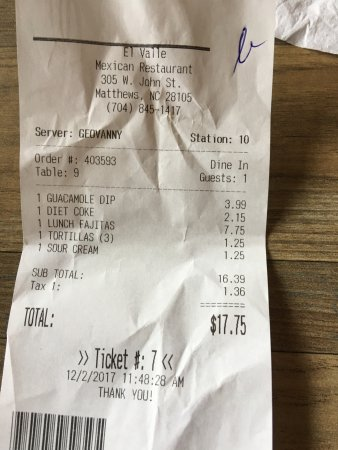

In [ ]:
from PIL import Image as PIL_Image
receipt = receipts[100]
receipt_filename = os.path.abspath(os.path.join('receipts', receipt))
receipt_image = PIL_Image.open(receipt_filename)
display(Image(receipt_filename))

Now we prompt...

In [ ]:
"""Single shot attempt at extracting all receipt information"""
response = model.generate_content(
    [
    """The image of the receipt below has information about all items purchased along with taxes, subtotal, total and business information.
                Extract only the information that's available in the receipt image and return a well formatted response""", receipt_image
    ],
    safety_settings=safety_settings)

print(response.text)


El Valle
Mexican Restaurant
305 W. John St.
Matthews, NC 28105
(704) 845-1417

Server: GEDVANNY
Station: 10

Order #: 403593
Table: 9

Dine In
Guests: 1

1 GUACAMOLE DIP     3.99
1 DIET COKE        2.15
1 LUNCH FAJITAS     7.75
1 TORTILLAS (3)    1.25
1 SOUR CREAM        1.25

SUB TOTAL:      16.39
Tax 1:          1.36

TOTAL:          $17.75

>> Ticket #: 7 <<
12/2/2017 11:48:28 AM

THANK YOU!

Gemini 1.5 seems to have a good handle on images. However, this is not really helpful if the plan is to use this receipt data for something actionable.

The response needs to be formatted to JSON This can be achieved with the wonderful instructor model which translates pydantic models to gemini functions. A schema will be defined with enough description of the data that will be extracted from the receipt image.

In [ ]:
import datetime
from typing import List
from pydantic import BaseModel, Field

class InvoiceItem(BaseModel):
    name: str = Field(..., description="The name of the item purchased.")
    quantity: int = Field(..., description="The quantity of items purchased.")
    price: float = Field(..., description="The amount of the current line item.")
    category: str = Field(..., description="The closest category this item belongs to.")

class ReceiptDetail(BaseModel):
    currency: str = Field(..., description="The name of the currency.")
    business_name: str = Field(..., description="The name of the business where this receipt was created.")
    created: datetime.datetime = Field(..., description="The date this receipt was created.")
    address: List[str] = Field(..., description="A line by line list of the component of the address of the business.")
    phone: str = Field(..., description="The phone number of this business.")
    teller: str = Field(..., description="This is the teller, server or employee that handled the payment for this receipt.")
    order_no: str = Field(..., description="This is the order number for this reciept that usually appears at the top of the receipt.")
    invoice_items: List[InvoiceItem] = Field(..., description="A list of line by line items that were purchased in the receipt.")
    subtotal: float = Field(..., description="This subtotal amount of this receipt.")
    taxes: List[float] = Field(..., description="A list of any taxes applied to this receipt.")
    total: float = Field(..., description="This total amount of this receipt.")

The instructor library works by `monkey patching` whatever llm is being used. It enhances the original prompt with a system message that `instructs` the llm to generate a valid json based on a schema. It further adds a tool to the llm with the specification for the schema.

In [ ]:
import instructor

"""Single shot attempt at extracting all receipt information"""
messages = [
    {
        "role": "user",
        "content":  "extract the receipt from the image\n"
    },
    {
        "role": "user",
        "content":  receipt_image
    }
]
client = instructor.from_gemini(
    client=model,
    mode=instructor.Mode.GEMINI_JSON,
)
resp = client.chat.completions.create(
    messages=messages,
    strict=True, #keeps the response content close to the source
    response_model=ReceiptDetail,
)
print(resp)

ReceiptDetail(
    currency='$',
    business_name='El Valle Mexican Restaurant',
    created=datetime.datetime(2017, 12, 22, 11, 48, 28),
    address=['305 W. John St.', 'Matthews, NC 28105', '(704) 845-1417'],
    phone='(704) 845-1417',
    teller='GEDVANNY',
    order_no='403593',
    invoice_items=[
        InvoiceItem(name='GUACAMOLE DIP', quantity=1, price=3.99, category='Appetizer'),
        InvoiceItem(name='DIET COKE', quantity=1, price=2.15, category='Drink'),
        InvoiceItem(name='LUNCH FAJITAS', quantity=1, price=7.75, category='Entree'),
        InvoiceItem(name='TORTILLAS (3)', quantity=1, price=1.25, category='Side'),
        InvoiceItem(name='SOUR CREAM', quantity=1, price=1.25, category='Side')
    ],
    subtotal=16.39,
    taxes=[1.36],
    total=17.75
)

Now that looks caliente 🔥. It accurratel picked out all the relevant information that was defined in the schema.

### Step 3 | Validate Extracted JSON

This is more of a note than a step.

Pydantic handles validation using the json schema defined by the model, however, thanks to the word Generative in GenAI LLM's tend to create or hallucinate content that may pass validation.

For this reason, you may need to have some other way of validating that the generated receipt details are correct.

### Step 4 | You know where this is going...

👇

### Step 5 | High 5

Congrats, you sat through the whole post and probalbly learnt something. High 5's for you.

![](https://media.tenor.com/VrxpcckTe2gAAAAi/hi5.gif)


## Next steps

Get the jupyter book @ here

### Part 2
In part 2, i will take this simple receipt scanner and turn it into a state aware pipeline for handling receipt scanning requests using `burr`.

Stay tuned.

### Let's connect

Getting in touch with me every where you see my name.
[osiloke.com](https://osiloke.com)

[x.com/osiloke](https://x.com/osiloke) |
[linkedin.com/in/osiloke](https://linkedin.com/in/osiloke) |
[github.com/osiloke](https://github.com/osiloke) |
[facebook.com/osiloke](https://facebook.com/osiloke) |
[instagram.com/osiloke](https://instagram.com/osiloke)